In [65]:
#modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GATConv,GCNConv
from torch.autograd import Variable
from torch_geometric.data import Data,HeteroData

import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder

# Data Preprocessing

In [66]:
def data_preprocessing(client_movie_rating_path,client_embeddings_path,movie_embeddings_ds_path):
    #Data preprocessing
    client_movie_rating_ds = pd.read_csv(client_movie_rating_path, sep='\t', names=["user id", "movie id", "rating", "timestamp"])
    client_movie_rating_df = pd.DataFrame(client_movie_rating_ds)


    client_embeddings_ds = pd.read_csv(client_embeddings_path, sep='|', names=["user id", "age", "gender", "occupation","zip_code"])
    client_embeddings_df = pd.DataFrame(client_embeddings_ds)


    # Specify the column names for the u.item file
    column_names = ['movie id', 'movie title', 'release date', 'video release date', 'imdb URL', 'unknown',
                   'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary',
                   'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                   'Thriller', 'War', 'Western']

    # Read the TSV file into a DataFrame
    movie_embeddings_ds = pd.read_csv(movie_embeddings_ds_path, sep='|', names=column_names,encoding='ISO-8859-1')
    movie_embeddings_df = pd.DataFrame(movie_embeddings_ds)

    #droping unwanted columns
    client_movie_rating_df = client_movie_rating_df.drop(["timestamp"], axis=1)
    client_embeddings_df = client_embeddings_df.drop(["zip_code"], axis=1)
    movie_embeddings_df = movie_embeddings_df.drop(['movie title', 'release date', 'video release date', 'imdb URL'], axis=1)

    # Label encode the 'Gender' column
    label_encoder = LabelEncoder()
    client_embeddings_df['gender'] = label_encoder.fit_transform(client_embeddings_df['gender']).astype(int)

    #one-hot encode the occupations
    client_embeddings_df = pd.get_dummies(client_embeddings_df, columns=['occupation']).astype(int)
    
    return client_movie_rating_df.astype(int),client_embeddings_df.astype(int),movie_embeddings_df.astype(int)

In [67]:
#training+validation set
client_movie_rating_path,client_embeddings_path,movie_embeddings_ds_path =\
"ml-100k/u1.base","ml-100k/u.user","ml-100k/u.item"
train_client_movie_rating_df,train_client_embeddings_df,train_movie_embeddings_df = \
data_preprocessing(client_movie_rating_path,client_embeddings_path,movie_embeddings_ds_path)

#testing set
client_movie_rating_path,client_embeddings_path,movie_embeddings_ds_path =\
"ml-100k/u1.test","ml-100k/u.user","ml-100k/u.item"
test_client_movie_rating_df,test_client_embeddings_df,test_movie_embeddings_df = \
data_preprocessing(client_movie_rating_path,client_embeddings_path,movie_embeddings_ds_path)

## Model

In [68]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(hidden_channels, 128)
        self.conv2 = GCNConv(128, hidden_channels)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class RatingClassifier(nn.Module):
    def __init__(self):
        super(RatingClassifier, self).__init__()
        # Define the linear layer that will take the dot product of user and movie embeddings
        self.prediction_layer = nn.Linear(1, 5)  # Assuming we predict a rating from 1 to 5

    def forward(self, user_embeddings, movie_embeddings):
        # Compute the dot product of the user and movie embeddings

        dot_product = torch.mm(user_embeddings.reshape(1,256), movie_embeddings.t()).t()  # Assuming both are 2D tensors
        
#         prediction = self.prediction_layer(dot_product)
#         # Apply the non-linear activation function (e.g., softmax for multi-class prediction)
#         prediction = torch.softmax(prediction, dim=1)  # For multi-class prediction
#         print(prediction.shape)
        return dot_product


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.gnn = GNN(hidden_channels)
        self.classifier = RatingClassifier()
        self.encoding = None
    def forward(self, data):

        encoding = self.gnn(data.x, data.edge_index)
        self.encoding = encoding

        pred = self.classifier(
            encoding[0],
            encoding[1:]
        )

        return pred
    
    def get_encoding(self):
        return self.encoding
    

In [69]:
FAIRNESS_PARAMETER = 0.1

## Federated Network Design

In [70]:
#Federated Model(model wrapper)
class Federated_Model:
    '''
    Wrap the model with optimizer and loss function
    '''
    def __init__(self,inital_weights,device):
        self.model = None
        self.optimizer = None
        self.criterion = None
        self.device = device
        
        self.initialize_model(initial_weights)

    def initialize_model(self, initial_weights):
        self.model = Model(256)
        if initial_weights != None:
            self.model.load_state_dict(initial_weights)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()  #Square Root taken later in training to make RMSE
        
    def get_encoding(self):
        return self.model.get_encoding()


In [71]:
#Client
class Client(Federated_Model):
    '''
    Client in the FL, inheret the same model architecture
    it carries its id, interacted items, embeddings of interacted items
    It also capable of obtain the corresponding training and validation set.
    some key states:
    client_movie_rating_df: pandas dataframe containing three columns:
                            client_id(iteself), interacted movie id,
                            the ratings for each movie
    
    movie_embeddings_df: embeddings for all the movie(including movies not interacted)
    client_embeddings_df: client embeddings, first element is the current client
                          rest of elements is the neighbours of the clients
    '''
    def __init__(self,client_id,client_movie_rating_df, movie_embeddings_df,client_embeddings_df, initial_weights, device):
        super().__init__(initial_weights, device)
        
        self.id = client_id
        
        self.client_movie_rating_df = client_movie_rating_df
        self.movie_embeddings_df = movie_embeddings_df
        self.client_embeddings_df = client_embeddings_df
        self.user_embedder = None
        
        #Fairness related dataset
        #The counterfactual dataset will be embedded through user_embedder
        self.counterfactual_client_df = None
        self.counterfactual_client_embbedding_df = None
        self.counterfactual_training_data = None
        self.counterfactual_testing_data = None
        
        #training_fairness_metric
        self.training_fairness = None

        
        #training and testing masks
        self.train_idx = None
        self.valid_idx = None
        
        
        self.training_data = None
        self.testing_data = None
        
        self.neighbors = None
        self.initialize_client()

    def initialize_client(self):
        #creating embedder to embed the current client information
        in_feature = self.client_embeddings_df.shape[1]-1
        self.user_embedder = nn.Linear(in_feature, 256)
        nn.init.xavier_uniform_(self.user_embedder.weight)
        
        self.counterfactual_dataset_constructor()
        
        self.train_idx, self.valid_idx = self.train_valid_split()
        
        self.split_data_and_create_graphs()
    
    
    def split_data_and_create_graphs(self):
        '''
        Generate the interacted movie embeddings,
        form the training and validation set
        x: movie embedding
        y: client id, movie id and rating
        '''
        self.movie_embeddings_df = self.movie_embeddings_df[
            self.movie_embeddings_df
            ['movie id'].isin(self.client_movie_rating_df["movie id"])]
        self.train_x_df = self.movie_embeddings_df.iloc[self.train_idx]
        self.valid_x_df = self.movie_embeddings_df.iloc[self.valid_idx]
        self.train_y_df = self.client_movie_rating_df.iloc[self.train_idx]
        self.valid_y_df = self.client_movie_rating_df.iloc[self.valid_idx]
        
        self.create_graph_data()
    
    def create_graph_data(self):
        '''
        Given training dataset, we convert it to graph first then convert to
        pytorch.geometric.Data type that can be applied by geometric module =
        '''
        self.training_data, self.counterfactual_training_data = self.dataset_to_graph(self.train_y_df, self.train_x_df)


        self.valid_data,self.counterfactual_testing_data = self.dataset_to_graph(self.valid_y_df, self.valid_x_df)

    def dataset_to_graph(self, client_movie_rating_df, movie_embeddings_df):
        '''
        Given the dataset relate to the client we convert to the format that is acceptable to
        Pytorch Geometric, which is following:
        x: tensor,each row represents features of the node
        y: tensor,ratings for each edge
        edge_index: tensor, first row is the starting node index, second row is destination node index
        client_movie_rating_df: client id, movie id and rating for the movie
        movie_embedding_df: movie id, movie embedding
        '''
        
        #constructing edge index
        edges_start = [0]*(len(client_movie_rating_df)) + [i for i in range(1, len(client_movie_rating_df)+1)]
        edges_end = [i for i in range(1, len(client_movie_rating_df)+1)]+[0]*(len(client_movie_rating_df))      
        edge_index = torch.tensor([edges_start, edges_end], dtype=torch.long)
        
        # computing the user embedding
        temp = self.client_embeddings_df.drop('user id',axis=1).values
        client_embeddings_df_tensor = self.user_embedder(torch.tensor(temp).to(torch.float))
        client_embeddings_df_tensor = client_embeddings_df_tensor.detach().numpy()
        user_embedding = pd.DataFrame(client_embeddings_df_tensor)
        
        # computing the counterfactual user embedding
        temp = self.counterfactual_client_df.drop('user id',axis=1).values
        cf_client_embeddings_df_tensor = self.user_embedder(torch.tensor(temp).to(torch.float))
        cf_client_embeddings_df_tensor = cf_client_embeddings_df_tensor.detach().numpy()
        cf_user_embedding = pd.DataFrame(cf_client_embeddings_df_tensor)
        
        #constructing the dataset
        x = user_embedding.values #User Embeddings
        embeddings_col = movie_embeddings_df.drop("movie id",axis=1).values
        x = np.vstack((x, embeddings_col))
        x = torch.tensor(np.array(x), dtype=torch.float) #Converting embeddings array into tensor
        
        cf_x = cf_user_embedding.values
        cf_x = np.vstack((cf_x, embeddings_col))
        cf_x = torch.tensor(np.array(cf_x), dtype=torch.float) #Converting embeddings array into tensor
        
        
        #constructing the edge attribute
        y = torch.tensor(client_movie_rating_df['rating'].values)
        
        #converting into Data type
        data = Data()
        data.x = x
        data.edge_index = edge_index
        data.edge_attr = y
        
        cf_data = Data()
        cf_data.x = cf_x
        cf_data.edge_index = edge_index
        cf_data.edge_attr = y
        
        return data, cf_data
    
    def train_valid_split(self):
        '''
        Obtain the masks for training and validation set
        '''
        # Shuffle client_movie_rating_df
        data_len = len(self.client_movie_rating_df)
        data_idx = list(range(data_len))
        random.shuffle(data_idx)

        # Split into training and validation set
        train_idx_end = round(data_len * 0.8)
        train_idx = data_idx[:train_idx_end]
        valid_idx = data_idx[train_idx_end:]

        return train_idx, valid_idx
    
    def print_client_info(self):
        message = "Client id: {}\n".format(self.id)
        print(message)
        print("client_movie_rating: \n", self.client_movie_rating_df)
        print("movie_embeddings_df: \n", self.movie_embeddings_df)
        print("client_embeddings_df: \n", self.client_embeddings_df)
        
    
    
    def update_to_global_weights(self, weights):
        self.model.load_state_dict(weights)
    
    def get_local_weights(self):
        return self.model.state_dict()
    
    
    def item_count(self):
        return len(self.movie_embeddings_df)
    
    
    def train_model(self, lr=0.005):
        for epoch in range(3):
            #Base
#             self.model.train()
#             self.optimizer.zero_grad()
#             out = self.model(self.training_data)
#             loss = torch.sqrt(self.criterion(out, self.training_data.edge_attr.float()))        
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.1)
#             self.optimizer.step()  
            ###############################################################33
            #Counterfactual
            self.model.train()
            self.optimizer.zero_grad()
            
            #encoding computation
            out = self.model(self.training_data)
            encoding = self.model.get_encoding().detach().numpy()
            
            cf_out = self.model(self.counterfactual_training_data)
            cf_encoding = self.model.get_encoding().detach().numpy()
            
            # fairness metric calculation
            pred_base = torch.round(out.data)
            pred_cf = torch.round(cf_out.data)
            self.training_fairness = pred_base.eq(pred_cf).sum().item()/len(self.train_idx)
            
            # Ls loss calculation
            L_s = np.linalg.norm(encoding - cf_encoding)
#             print("L_s loss is: \n",L_s.item())
            loss =  (1-FAIRNESS_PARAMETER) * torch.sqrt(self.criterion(out, self.training_data.edge_attr.float())) +  FAIRNESS_PARAMETER * L_s
#             print("Total loss is: \n",loss.item())

            
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.1)
            self.optimizer.step()
            
        return loss
    def get_training_fairness(self):
        return self.training_fairness
    def evaluate_model_with_fairness(self):
                #encoding computation
        data = self.valid_data

        self.model.eval()
        out = self.model(self.valid_data)
        loss = torch.sqrt(self.criterion(out, self.valid_data.edge_attr.float())) 
        pred = torch.round(out.data)
        correct = float(pred.eq(self.valid_data.edge_attr).sum().item())
        acc = correct / len(self.valid_data.edge_attr)    
        
        
        cf_out = self.model(self.counterfactual_testing_data)

        # fairness metric calculation
        pred_base = pred
        pred_cf = torch.round(cf_out.data)
        valid_fairness = pred_base.eq(pred_cf).sum().item()/len(self.valid_idx)
        return loss,acc,valid_fairness
    
    def evaluate_model(self, model=None):
        data = self.valid_data

        self.model.eval()
        out = self.model(self.valid_data)
        loss = torch.sqrt(self.criterion(out, self.valid_data.edge_attr.float())) 
        pred = torch.round(out.data)
        correct = float(pred.eq(self.valid_data.edge_attr).sum().item())
        acc = correct / len(self.valid_data.edge_attr)
        return loss,acc
    
    
    def counterfactual_dataset_constructor(self):
        '''
        The function generate the counterfactual dataset
        '''
        client_embedding_clone = self.client_embeddings_df.copy()
        client_embedding_clone['gender'] = client_embedding_clone['gender'].astype(bool)
        client_embedding_clone['gender'] = ~client_embedding_clone['gender'].astype(bool)
        client_embedding_clone['gender'] = client_embedding_clone['gender'].astype(int)
        
        self.counterfactual_client_df = client_embedding_clone

In [72]:
class Initializer:

    def __init__(self, device, initial_weights):
        
        self.client_movie_rating_df = None
        
        self.client_embeddings_df = None
        
        self.movie_embeddings_df = None
        
        self.clients = None

        self.train_clients_idx = None
        self.test_clients_idx = None
        self.initial_weights = initial_weights
        
        self.device = device
#         self.generate_items_embeddings()
        
        self.client_user_embeddings = None

        
        
        
    def df_load(self,client_movie_rating_df,client_embeddings_df,movie_embeddings_df):
        self.client_movie_rating_df = client_movie_rating_df
        self.client_embeddings_df = client_embeddings_df
        self.movie_embeddings_df = movie_embeddings_df

        
    def initialize_clients(self):        
        # RANDOMLY SELECTING TEST/TRAIN CLIENTS
        self.clients = [Client(client_id=user_idx, 
                              client_movie_rating_df=self.client_movie_rating_df[self.client_movie_rating_df['user id'] == user_idx], 
                              client_embeddings_df = self.client_embeddings_df[self.client_embeddings_df['user id'] == user_idx], 
                              movie_embeddings_df = self.movie_embeddings_df,

                              initial_weights=self.initial_weights,
                              device = device) for user_idx in self.client_movie_rating_df["user id"].unique()]
        
            
    def generate_items_embeddings(self):
        '''
        Since the feature length is different for movie and user, here
        we perform an embedding for movie globally
        '''
        #prepare embedder for the movie feature
        in_features = self.movie_embeddings_df.shape[1]-1        
        movie_embedder = nn.Linear(in_features, 256)
        nn.init.xavier_uniform_(movie_embedder.weight)
        
        #apply the embedder
        temp = self.movie_embeddings_df.drop('movie id',axis=1).values
        movie_embeddings_df_tensor = movie_embedder(torch.tensor(temp).to(torch.float))

        #convert and add back to dataframe
        movie_embeddings_df_tensor = movie_embeddings_df_tensor.detach().numpy()
        embedding = pd.DataFrame(movie_embeddings_df_tensor)
        self.movie_embeddings_df =  pd.concat([self.movie_embeddings_df['movie id'], embedding], axis=1)
        

In [73]:
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

global_model = Model(256).to(device)

initial_weights=global_model.state_dict().copy()
train_init = Initializer(device,initial_weights)
train_init.df_load(train_client_movie_rating_df,train_client_embeddings_df,train_movie_embeddings_df)
train_init.generate_items_embeddings()
train_init.initialize_clients()

# train_init.clients[0].print_client_info()

In [74]:
#we now introduce federated framework
lost = []
train_lost=[]

ctls = []
cvls = []
caccs_l = []
ctfs = []
cvfs = []
initializer = train_init
for fair_para in [1,0.75,0.5,0.25,0.1,0]:
    FAIRNESS_PARAMETER = fair_para

    tls = []
    vls = []
    accs_l = []
    tfs = []
    vfs = []

    for client in train_init.clients:
        client.model.load_state_dict(initial_weights)
        
    for training_round in range(20):
        total_items = 0
        weights = []
        embeddings = [] 
        items_rated = []
        losses = []
        valid_losses = []
        accs = []
        training_fairness = []
        validation_fairness = []
        #select few clients for federated training
        selected_clients = random.sample(range(0, len(initializer.clients)), 128)

        #TRAIN THE NETWORK
        for client_idx in selected_clients:
            losses.append(initializer.clients[client_idx].train_model())
            total_items += initializer.clients[client_idx].item_count()
            weights.append(initializer.clients[client_idx].model.state_dict())
    #         embeddings.append(initializer.clients[client_idx].get_item_embeddings())
            items_rated.append(initializer.clients[client_idx].item_count())
    #         eval_result = initializer.clients[client_idx].evaluate_model()
    #         valid_losses.append(eval_result[0])
    #         accs.append(eval_result[1])
            training_fairness.append(initializer.clients[client_idx].get_training_fairness())
            eval_result = initializer.clients[client_idx].evaluate_model_with_fairness()
            valid_losses.append(eval_result[0])
            accs.append(eval_result[1])
            validation_fairness.append(eval_result[2])

        #UPDATE GLOBAL MODEL

        #WEIGHTED AVERAGE: 
        new_parameters = global_model.state_dict()
        for key in new_parameters:
            new_parameters[key] = weights[0][key]
            for i in range(1, len(weights)):
                new_parameters[key] += weights[i][key]*(items_rated[i])
            new_parameters[key]/=float(total_items)


        global_model.load_state_dict(new_parameters)


    #     #UPDATE GLOBAL EMBEDDINGS    
    #     df = pd.concat(i for i in embeddings)
    #     global_embeddings = df.groupby(by="movieId", as_index=False).mean()
    #     global_embeddings.reset_index()
        # EVALUATE

            # EVALUATE



        loss = 0
        for i in losses:
            loss += i
        loss/=128
        tls.append(loss.item())
        print('Training Loss [Local Model][Train Clients]: {:.4f}'.format(loss.item()))

        valid_loss = 0
        for i in valid_losses:
            valid_loss += i
        valid_loss/=128
        vls.append(valid_loss.item())
        print('Validation Loss [Local Model][Train Clients]: {:.4f}'.format(valid_loss.item()))

        acc = 0
        for i in accs:
            acc += i
        accs_l.append(acc/128)
    #     print('Validation Accuracy [Global Model][All Clients]: {:.4f}'.format(acc/128))

        tf = 0
        for i in training_fairness:
            tf += i
        tfs.append(tf/128)
    #     print('Training fairness [Global Model][All Clients]: {:.4f}'.format(tf/128))

        vf = 0
        for i in validation_fairness:
            vf += i
        vfs.append(vf/128)
    #     print('Validation fairness [Global Model][All Clients]: {:.4f}'.format(vf/128))
    #     print('\n')
    ctls.append(tls)
    cvls.append(vls)
    caccs_l.append(accs_l)
    ctfs.append(tfs)
    cvfs.append(vfs)
    print("hyperparamter:{}\n".format(fair_para))

Training Loss [Local Model][Train Clients]: 0.5293
Validation Loss [Local Model][Train Clients]: 75.8719
Training Loss [Local Model][Train Clients]: 0.5278
Validation Loss [Local Model][Train Clients]: 66.9072
Training Loss [Local Model][Train Clients]: 0.5168
Validation Loss [Local Model][Train Clients]: 71.9162
Training Loss [Local Model][Train Clients]: 0.5323
Validation Loss [Local Model][Train Clients]: 76.2259
Training Loss [Local Model][Train Clients]: 0.5306
Validation Loss [Local Model][Train Clients]: 85.5819
Training Loss [Local Model][Train Clients]: 0.5253
Validation Loss [Local Model][Train Clients]: 75.9850
Training Loss [Local Model][Train Clients]: 0.5233
Validation Loss [Local Model][Train Clients]: 71.8386
Training Loss [Local Model][Train Clients]: 0.5310
Validation Loss [Local Model][Train Clients]: 73.1346
Training Loss [Local Model][Train Clients]: 0.5270
Validation Loss [Local Model][Train Clients]: 60.8378
Training Loss [Local Model][Train Clients]: 0.5312
Vali

Training Loss [Local Model][Train Clients]: 1.2354
Validation Loss [Local Model][Train Clients]: 4.1632
Training Loss [Local Model][Train Clients]: 1.5696
Validation Loss [Local Model][Train Clients]: 4.7527
hyperparamter:0.25

Training Loss [Local Model][Train Clients]: 5.4450
Validation Loss [Local Model][Train Clients]: 11.2399
Training Loss [Local Model][Train Clients]: 5.2423
Validation Loss [Local Model][Train Clients]: 10.7486
Training Loss [Local Model][Train Clients]: 3.8567
Validation Loss [Local Model][Train Clients]: 8.4567
Training Loss [Local Model][Train Clients]: 4.2281
Validation Loss [Local Model][Train Clients]: 9.5493
Training Loss [Local Model][Train Clients]: 2.9002
Validation Loss [Local Model][Train Clients]: 6.8103
Training Loss [Local Model][Train Clients]: 3.2407
Validation Loss [Local Model][Train Clients]: 7.5858
Training Loss [Local Model][Train Clients]: 3.5657
Validation Loss [Local Model][Train Clients]: 7.9240
Training Loss [Local Model][Train Clients]

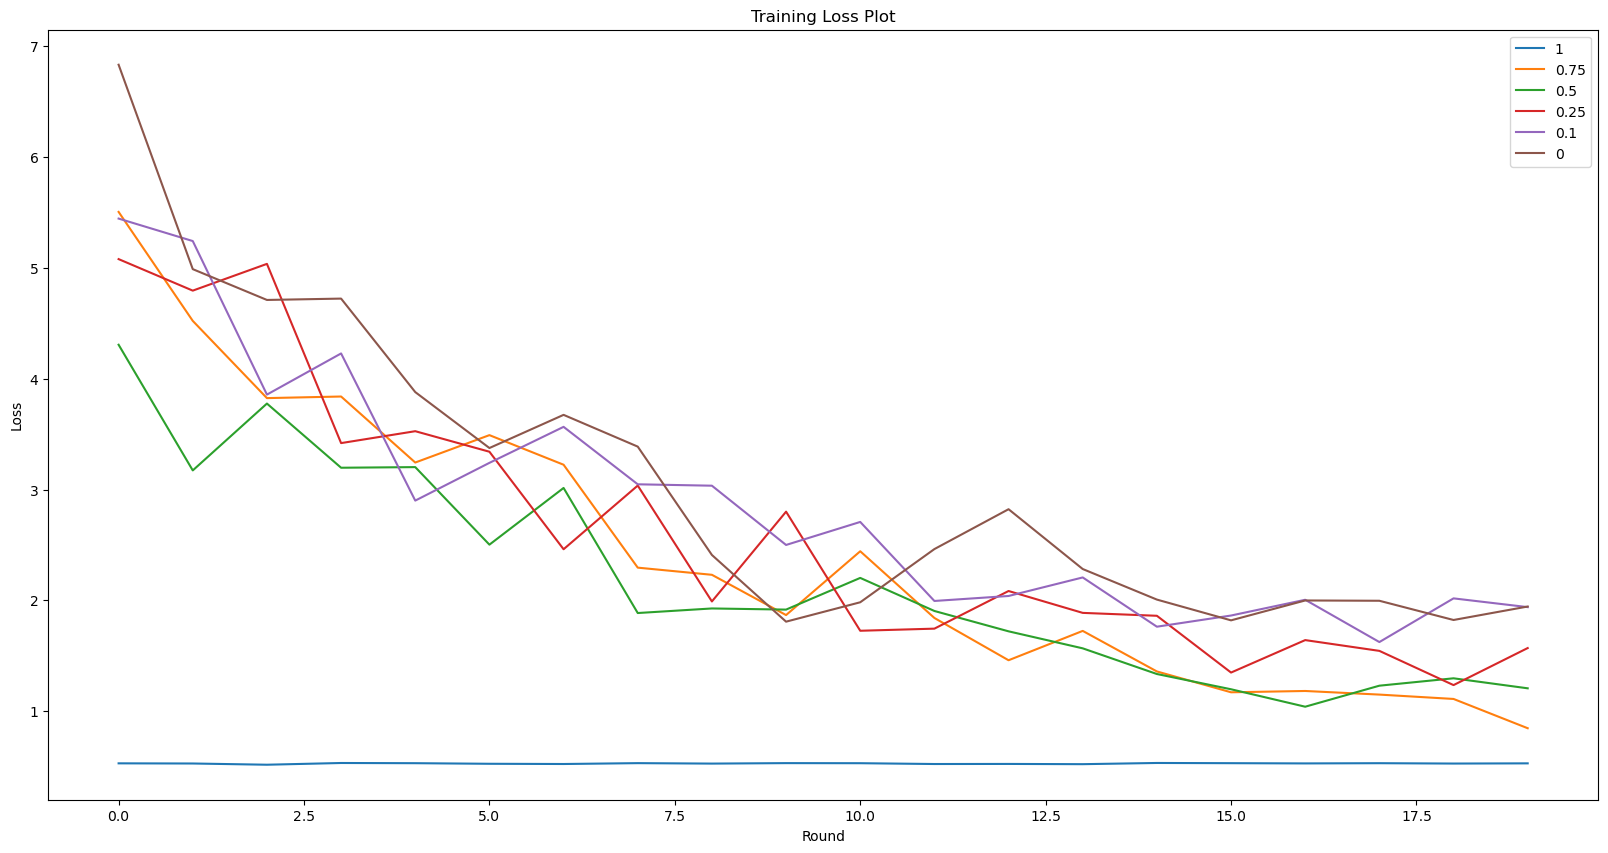

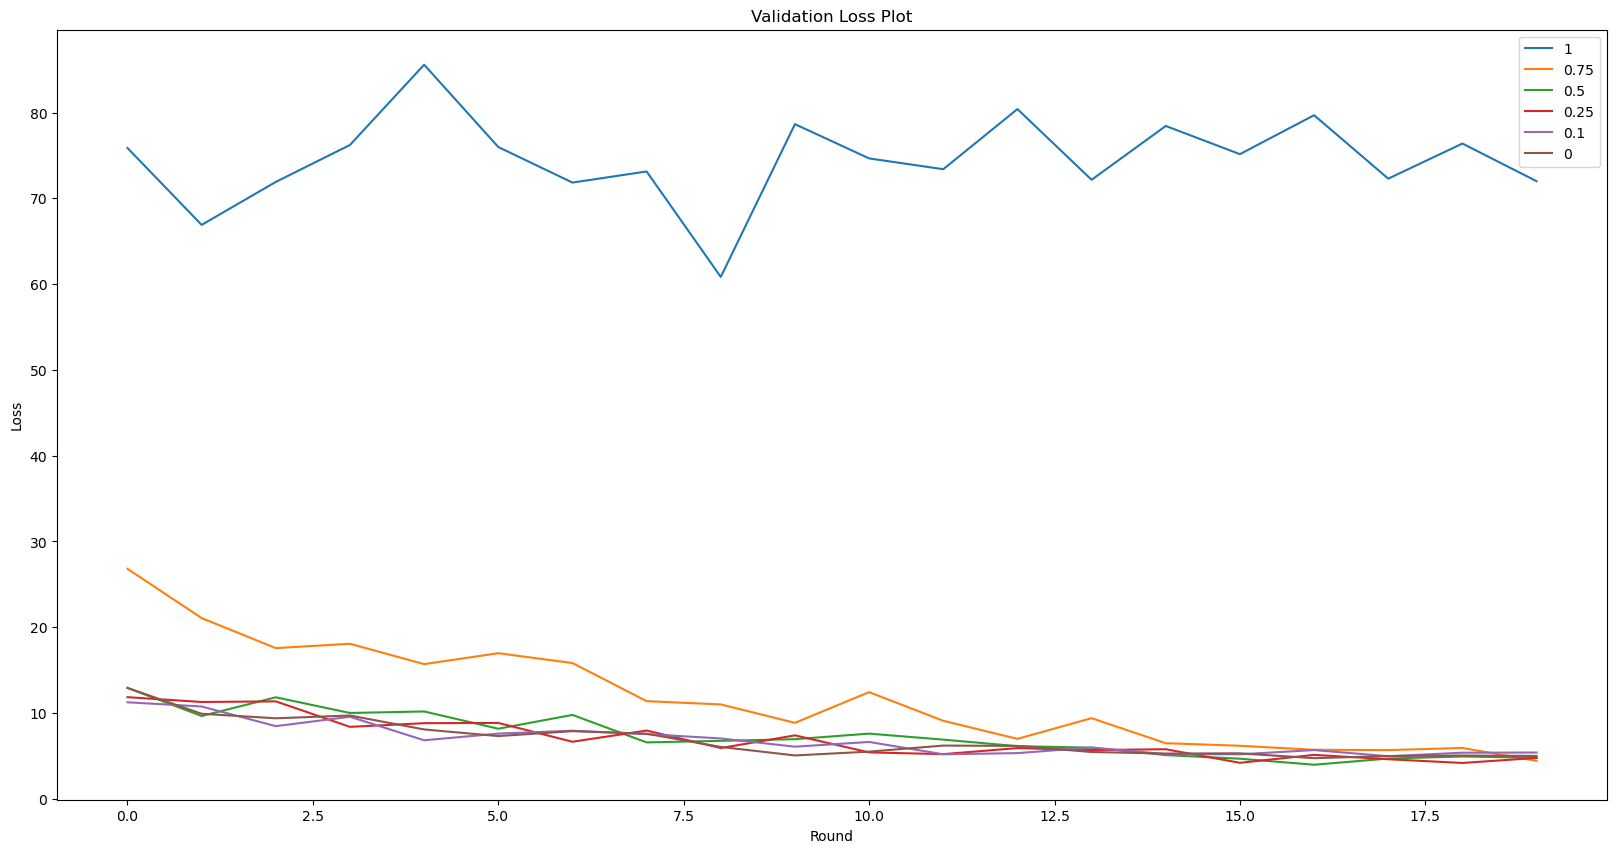

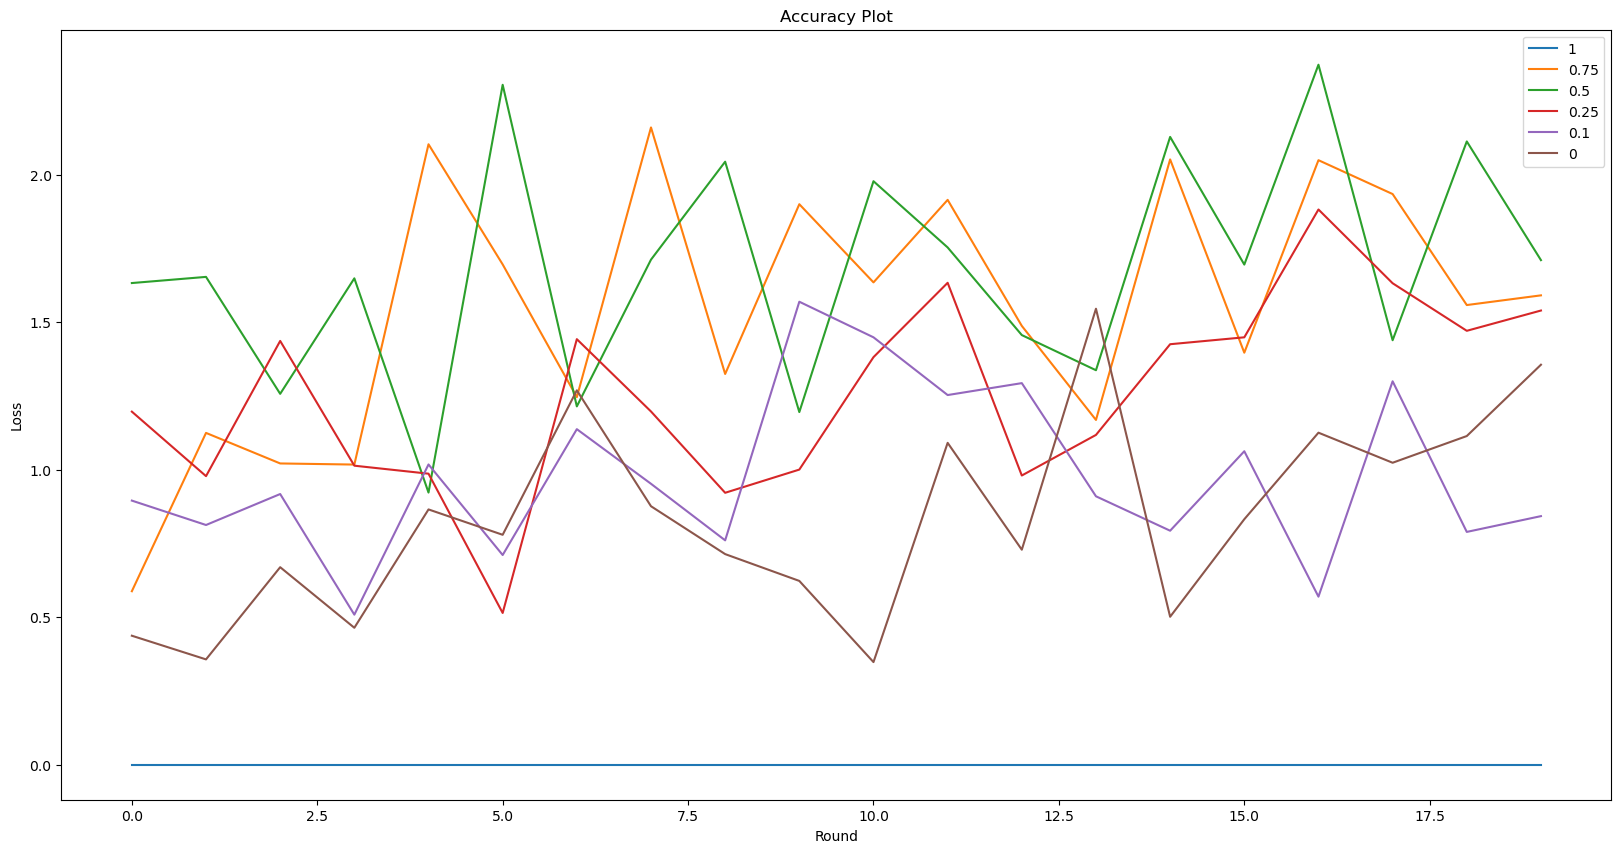

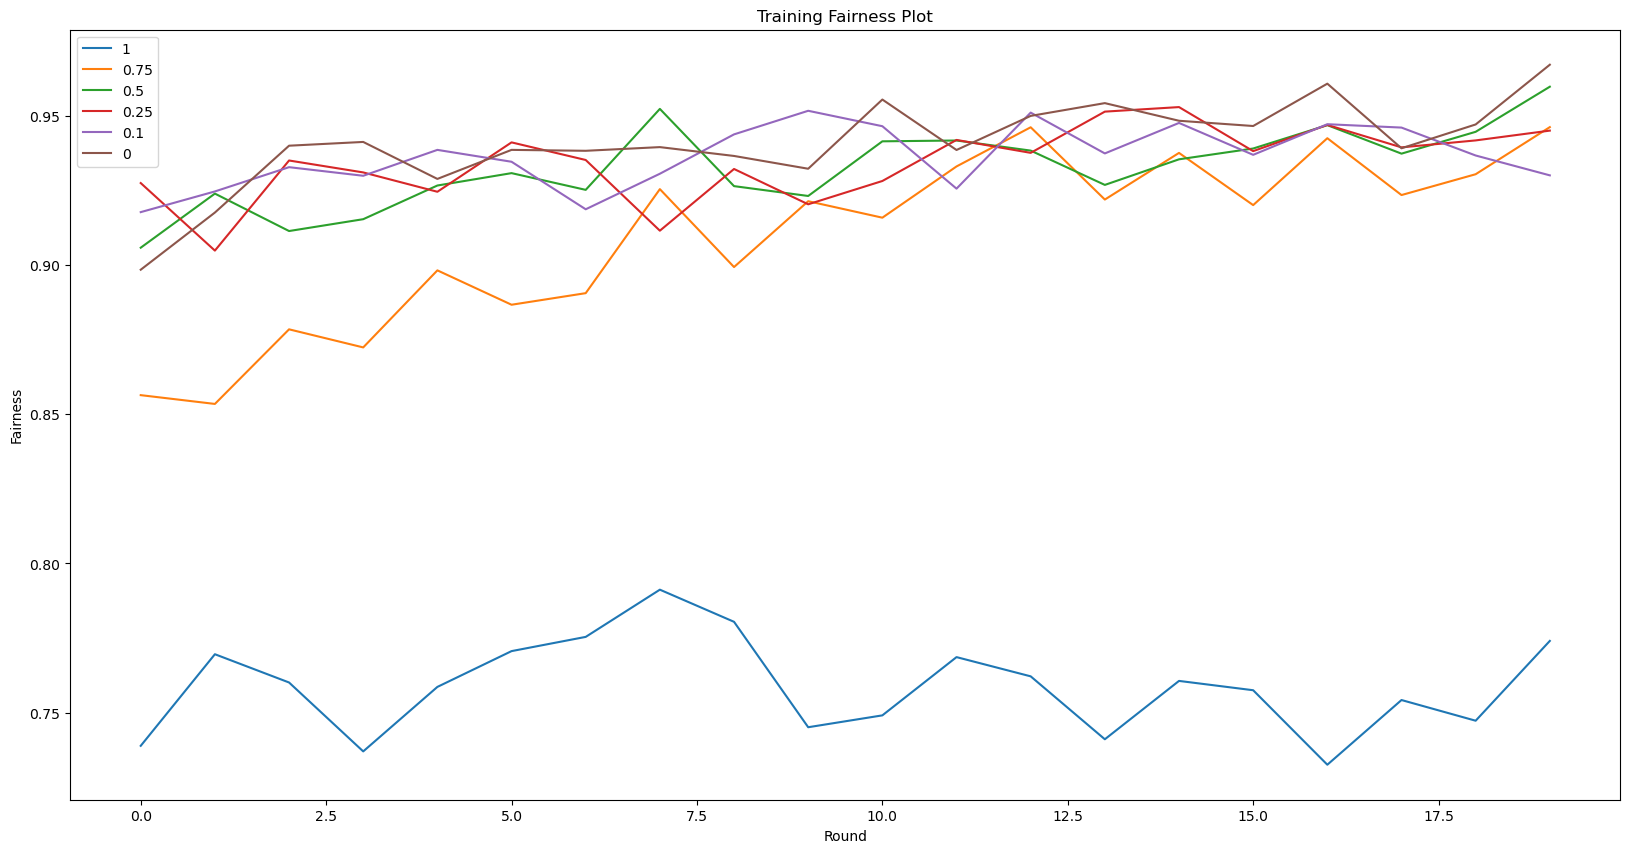

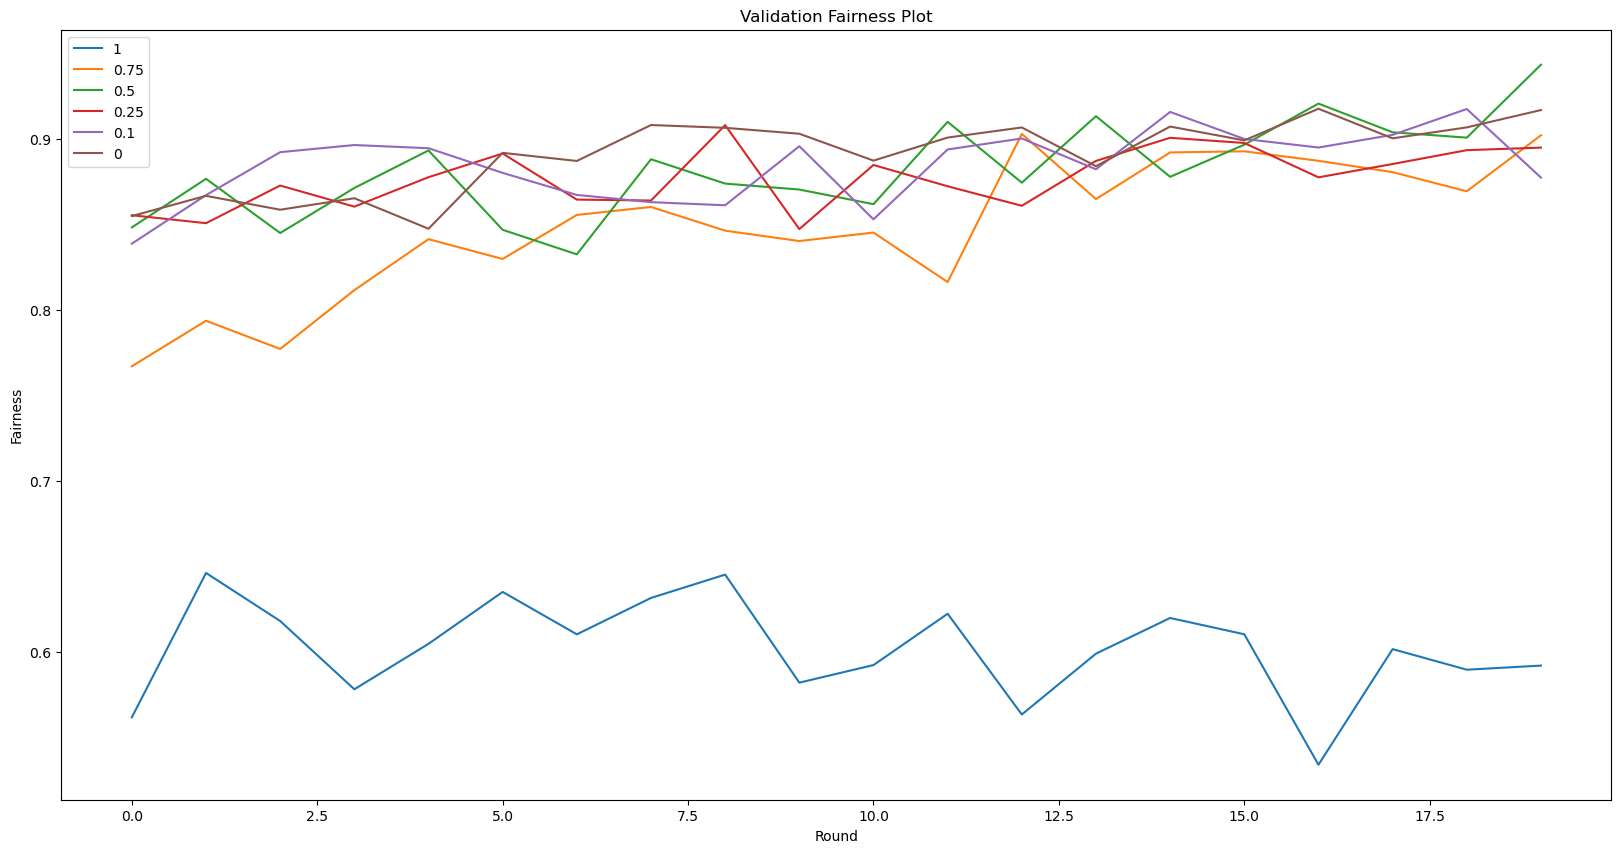

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
# Create the first subplot (1 row, 2 columns, first plot)
# plt.subplot(1, 3, 1)
for c in ctls:
    plt.plot(range(20), c)  # Plotting y1 on the first subplot
plt.title('Training Loss Plot')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend([1,0.75,0.5,0.25,0.1,0])
plt.show()


plt.figure(figsize=(20,10))
# plt.subplot(1, 3, 2)
for c in cvls:
    plt.plot(range(20), c)  # Plotting y1 on the first subplot
plt.title('Validation Loss Plot')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend([1,0.75,0.5,0.25,0.1,0])

plt.show()


plt.figure(figsize=(20,10))
# plt.subplot(1, 3, 3)
for c in caccs_l:
    plt.plot(range(20), c)  # Plotting y1 on the first subplot
plt.title('Accuracy Plot')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend([1,0.75,0.5,0.25,0.1,0])

plt.show()



plt.figure(figsize=(20,10))
# Create the first subplot (1 row, 2 columns, first plot)
# plt.subplot(1,2,1)
for c in ctfs:
    plt.plot(range(20), c)  # Plotting y1 on the first subplot
plt.title('Training Fairness Plot')
plt.xlabel("Round")
plt.ylabel("Fairness")
plt.legend([1,0.75,0.5,0.25,0.1,0])

plt.show()

plt.figure(figsize=(20,10))
for c in cvfs:
    plt.plot(range(20), c)  # Plotting y1 on the first subplot
plt.title('Validation Fairness Plot')
plt.xlabel("Round")
plt.ylabel("Fairness")
plt.legend([1,0.75,0.5,0.25,0.1,0])

plt.show()